# 

In [24]:
from scipy.stats import norm, invgamma, invwishart
import numpy as np

import matplotlib.pyplot as plt

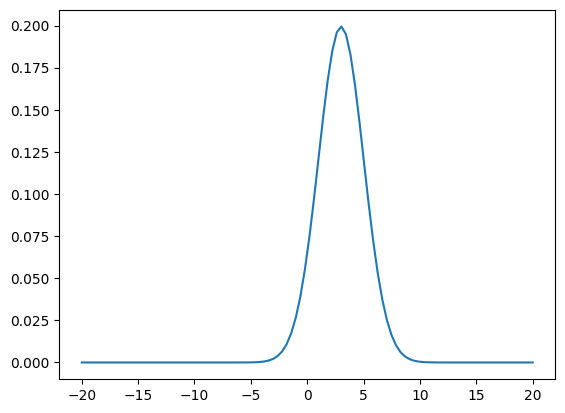

In [65]:
l = np.linspace(-20, 20, 100)
dist = norm(3, 2)

plt.plot(l, dist.pdf(l))
plt.show()

In [69]:
dist.cdf(6) - dist.cdf(0)

0.8663855974622838

In [70]:
dist.pdf(6), dist.pdf(0)

(0.06475879783294587, 0.06475879783294587)

In [77]:
N = 10000000
samples = dist.rvs(N)
(dist.pdf(samples) > dist.pdf(6)).sum()/N

0.8664306

array([4.27187038, 2.75912743, 1.05215158, 3.92836249, 3.74959483,
       3.06008598, 4.44901694, 2.465805  , 5.6650538 , 0.67224114])

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import invgamma, norm
from IPython.display import display
from scipy.special import gamma
from scipy.optimize import fsolve

dmu = (5+5)/1000
dsigma2 = (20-0.01)/1000
dA = dmu * dsigma2
# NIG 분포의 결합 확률밀도함수 정의 (평균과 분산에 대한)
def nig_joint_pdf(mu, sigma2, mu_0, lambda_, alpha, beta):
    # Normal part (mean = mu, variance = sigma2)
    norm_pdf = norm.pdf(mu, mu_0, np.sqrt(sigma2 / lambda_))
    
    # Inverse gamma part (variance = sigma2)
    invgamma_pdf = invgamma.pdf(sigma2, alpha, scale=beta)
    
    return norm_pdf * invgamma_pdf

# CDF에 해당하는 등고선 계산
def calculate_cdf_contour_level(pdf_values, target_cdf):
    # 확률밀도함수 값들을 1D로 변환한 후 정렬
    sorted_pdf = np.sort(pdf_values.flatten())[::-1]
    cumulative_sum = np.cumsum(sorted_pdf)
    cumulative_sum *= dA
    # cumulative_sum /= cumulative_sum[-1]  # 누적 합을 0~1 사이의 값으로 정규화
    
    # CDF에 해당하는 값을 찾기
    contour_value = sorted_pdf[np.searchsorted(cumulative_sum, target_cdf)]
    return contour_value

# 그래프 업데이트 함수
def update(mu_0, lambda_, alpha, beta, target_cdf):
    mu_values = np.linspace(-5, 5, 1000)
    sigma2_values = np.linspace(0.01, 20, 1000)
    
    # 그리드를 만들어 결합 확률 밀도를 계산
    mu_grid, sigma2_grid = np.meshgrid(mu_values, sigma2_values)
    pdf_values = nig_joint_pdf(mu_grid, sigma2_grid, mu_0, lambda_, alpha, beta)
    
    # 입력받은 CDF 값에 해당하는 등고선 값을 계산
    contour_level = calculate_cdf_contour_level(pdf_values, target_cdf)
    print("contour_level: ",contour_level)
    # 그래프 그리기
    plt.figure(figsize=(8, 6))
    plt.contourf(mu_grid, sigma2_grid, pdf_values, levels=np.linspace(0, pdf_values.max(), 100), cmap='viridis')
    plt.colorbar(label='Density')




    c = contour_level
    target_pdf_value = c / (gamma(alpha+0.5) / gamma(alpha) / np.sqrt(beta) *np.sqrt(lambda_) / np.sqrt(2*np.pi))
    def equation(x):
        return invgamma.pdf(x, alpha+0.5, scale=beta) - target_pdf_value

    # small
    # 초기 추정값 설정 후 방정식 해결
    initial_guess = 0.1
    small_y = fsolve(equation, initial_guess)[0]
    
    # large
    # 초기 추정값 설정 후 방정식 해결
    initial_guess = 20
    large_y = fsolve(equation, initial_guess)[0]


    y = np.exp((np.log(np.sqrt(lambda_)*beta**alpha/(np.sqrt(2*np.pi)*gamma(alpha)))-np.log(c))/(alpha+3/2)-1)
    x = np.sqrt(-2*y/lambda_*np.log(c/invgamma.pdf(y,alpha,scale=beta)*np.sqrt(2*np.pi*y)/np.sqrt(lambda_)))
    plt.axvline(x=mu_0+x, color='y', linestyle='--')
    plt.axvline(x=mu_0-x, color='y', linestyle='--')
    
    # plt.axhline(y=1.8042617241070633, color='g', linestyle='--')
    plt.axhline(y=small_y, color='y', linestyle='--')
    plt.axhline(y=large_y, color='y', linestyle='--')


    
    # CDF에 해당하는 등고선 그리기
    plt.contour(mu_grid, sigma2_grid, pdf_values, levels=[contour_level], colors='red', linewidths=2)
    plt.title(f'NIG PDF with μ₀={mu_0:.4f}, λ={lambda_:.4f}, α={alpha:.4f}, β={beta:.4f} and CDF = {target_cdf:.4f}')
    plt.xlabel('Mean (μ)')
    plt.ylabel('Variance (σ²)')
    plt.grid(True)
    plt.show()

# 파라미터 조절 위젯 생성
mu_0_slider = widgets.FloatSlider(value=0, min=-5, max=5, step=0.1, description='μ₀ (prior mean)')
lambda_slider = widgets.FloatSlider(value=1, min=0.1, max=10, step=0.1, description='λ (precision)')
alpha_slider = widgets.FloatSlider(value=2, min=0.1, max=10, step=0.1, description='α (shape)')
beta_slider = widgets.FloatSlider(value=2, min=0.1, max=10, step=0.1, description='β (scale)')
cdf_slider = widgets.FloatSlider(value=0.5, min=0.01, max=0.99, step=0.01, description='Target CDF')

# 대화형 위젯으로 출력
ui = widgets.VBox([mu_0_slider, lambda_slider, alpha_slider, beta_slider, cdf_slider])
out = widgets.interactive_output(update, {
    'mu_0': mu_0_slider, 
    'lambda_': lambda_slider, 
    'alpha': alpha_slider, 
    'beta': beta_slider, 
    'target_cdf': cdf_slider
})

display(ui, out)


Output()

In [121]:
N = 10000000
mu_0, lambda_, alpha, beta = 0, 1, 2, 2
sigma2 = invgamma(alpha, scale=beta).rvs(N)
x = norm(mu_0, np.sqrt(sigma2 / lambda_)).rvs(N)
p = invgamma(alpha, scale=beta).pdf(sigma2) * norm(mu_0, np.sqrt(sigma2 / lambda_)).pdf(x)
# (p > 0.08424628126090453).sum() / N
(p > 0.0877166530258724).sum() / N
(p > 0.004345568823141012).sum() / N

0.9016762

In [229]:
mu_x = np.linspace(-5, 5, 10)
mu_y = np.linspace(-5, 5, 10)

L_11 = np.linspace(0.1, 10, 10)
L_21 = np.linspace(0, 10, 10)
L_22 = np.linspace(0.1, 10, 10)

dx = (5+5)/10
dy = (5+5)/10

dL_11 = 10 / 10
dL_21 = 10 / 10
dL_22 = 10 / 10

dV = dx * dy * dL_11 * dL_21 * dL_22

In [230]:
x_grid, y_grid = np.meshgrid(mu_x, mu_y)
L11_grid, L21_grid, L22_grid = np.meshgrid(L_11, L_21, L_22)

In [220]:
from tqdm import tqdm

(10, 10)

In [231]:

sigma2_grid_points = np.c_[L11_grid.ravel(), L21_grid.ravel(), L22_grid.ravel()]
print(sigma2_grid_points.shape)
valid_covariances = []
for a, b, c in tqdm(sigma2_grid_points):
    covariance_matrix = np.array([[a, 0], [b, c]]) @ np.array([[a, 0], [b, c]]).T
    if np.linalg.det(covariance_matrix) > 0:  # Check positive definiteness
        valid_covariances.append(covariance_matrix)

valid_covariances = np.array(valid_covariances)

p_values = list()
for cov in tqdm(valid_covariances):
    p_values.append(invwishart(df=2, scale=Psi).pdf(cov))


(1000, 3)


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5277.81it/s]


In [302]:
len(p_values)

1000

In [233]:
p = np.array(p_values)
(p > 0.001).sum()

3

In [322]:
N = 1000000
covs = invwishart(df=2, scale=Psi).rvs(N)
sample_list = list()
for cov in tqdm(covs):
    try:
        mu = multivariate_normal(mean=[0,0], cov=cov).rvs(1)
    except:
        continue
    sample_list.append((mu, cov))

100%|███████████████████████████████| 1000000/1000000 [03:05<00:00, 5376.84it/s]


In [298]:
len(sample_list)

99997

In [325]:
p_list = list()
for sample in tqdm(sample_list):
    mu, cov = sample
    Sigma_p = invwishart(df=2, scale=Psi).pdf(cov)
    mu_p = multivariate_normal(mean=[0,0], cov=cov).pdf(mu)
    p = Sigma_p * mu_p
    p_list.append(p)
p_list = np.array(p_list)

100%|█████████████████████████████████| 999958/999958 [05:02<00:00, 3300.28it/s]


In [366]:
(p_list > 0.00000000178).sum() / N

0.900007

In [321]:
len(p_list)

99997

In [236]:
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
valid_covariances.shape
# multivariate_normal(mean=[0,0], cov=valid_covariances).pdf(grid_points)

(1000, 2, 2)

In [210]:
invwishart(df=2, scale=Psi).pdf(Psi)

0.02927491576215958

In [307]:
import numpy as np
from scipy.stats import multivariate_normal

# 1. 2차원 다변량 정규분포 파라미터 설정
mu = np.array([0, 0])  # 평균
sigma = np.array([[1, 0.5], [0.5, 1]])  # 공분산 행렬
dist = multivariate_normal(mean=mu, cov=sigma)

# 2. Monte Carlo 샘플링
N = 10**6  # 샘플 개수
samples = np.random.multivariate_normal(mu, sigma, N)

# 3. 샘플의 확률 밀도 계산
pdf_values = dist.pdf(samples)  # 각 샘플의 확률 밀도

# 4. 누적 확률 계산 (90%에 해당하는 경계 확률값 찾기)
sorted_pdf = np.sort(pdf_values)  # 확률 밀도 정렬
cumulative = np.cumsum(sorted_pdf) / np.sum(sorted_pdf)  # 누적 분포 계산
threshold_index = np.searchsorted(cumulative, 0.9)  # 90%에 해당하는 인덱스
threshold_pdf = sorted_pdf[threshold_index]  # 90%에 해당하는 확률 밀도값

# 5. 검증 (90% 포함 여부 확인)
inside_90_percent = np.mean(pdf_values >= threshold_pdf)

print(f"90% CDF Contour의 확률 밀도 경계값: {threshold_pdf}")
print(f"90% 포함된 비율 (검증): {inside_90_percent*100:.2f}%")


90% CDF Contour의 확률 밀도 경계값: 0.17439623273917654
90% 포함된 비율 (검증): 5.13%


In [305]:
print("Sample Mean:", np.mean(samples, axis=0))


Sample Mean: [0.00155549 0.00083745]


(1000, 3)


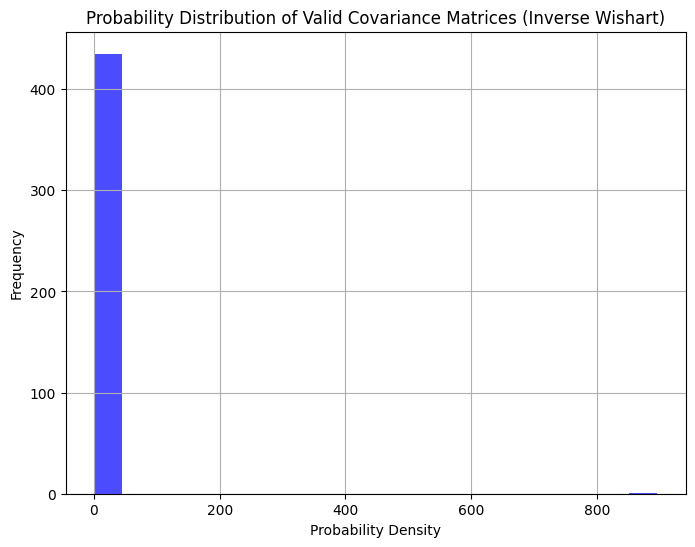

In [162]:
from scipy.stats import invwishart

# Define grid for covariance matrix elements
# Assuming 2x2 covariance matrix with elements: [[a, b], [b, c]]
a_values = np.linspace(0.1, 10, 10)  # Diagonal element (a)
b_values = np.linspace(0, 10, 10)   # Off-diagonal element (b)
c_values = np.linspace(0.1, 10, 10)  # Diagonal element (c)

# Create a grid for the elements
a_grid, b_grid, c_grid = np.meshgrid(a_values, b_values, c_values)
covariances = np.c_[
    a_grid.ravel(),  # a
    b_grid.ravel(),  # b
    c_grid.ravel()   # c
]
print(covariances.shape)
# Filter out invalid covariance matrices (e.g., where determinant <= 0)
valid_covariances = []
for a, b, c in covariances:
    covariance_matrix = np.array([[a, b], [b, c]])
    if np.linalg.det(covariance_matrix) > 0:  # Check positive definiteness
        valid_covariances.append(covariance_matrix)

# Convert list back to array for further processing
valid_covariances = np.array(valid_covariances)

# Define Inverse Wishart parameters
nu = 10  # Degrees of freedom
Psi = np.eye(2)  # Scale matrix

# Compute probabilities for valid covariance matrices
probabilities = [
    invwishart.pdf(cov_matrix, df=nu, scale=Psi)
    for cov_matrix in valid_covariances
]

# Reshape probabilities for visualization
probabilities = np.array(probabilities)

# Plot histogram of probabilities for valid covariance matrices
plt.figure(figsize=(8, 6))
plt.hist(probabilities, bins=20, color='blue', alpha=0.7)
plt.title("Probability Distribution of Valid Covariance Matrices (Inverse Wishart)")
plt.xlabel("Probability Density")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [368]:
import numpy as np

# 주어진 공분산 행렬과 평균 벡터
mu = np.array([0, 0])  # 평균 벡터
sigma = np.array([[1, 0.5], [0.5, 1]])  # 공분산 행렬

# 샘플 데이터 생성
N = 100000  # 샘플 개수
samples = np.random.multivariate_normal(mu, sigma, N)

# 1. Cholesky 분해
L = np.linalg.cholesky(sigma)  # Cholesky 분해 결과

# 2. 변환 행렬 L의 역행렬 계산
L_inv = np.linalg.inv(L)

# 3. 데이터 표준화
standardized_samples = (samples - mu) @ L_inv.T

# 검증: 표준화된 데이터의 공분산 확인
standardized_cov = np.cov(standardized_samples, rowvar=False)
print("표준화된 데이터의 공분산 행렬:")
print(standardized_cov)


표준화된 데이터의 공분산 행렬:
[[1.00074284 0.00200382]
 [0.00200382 1.00412431]]


In [138]:
invwishart(df=nu, scale=Psi).pdf([[s11_grid, s12_grid], [s12_grid, s22_grid]])

ValueError: Quantiles must be at most two-dimensional with an additional dimension for multiplecomponents, but x.ndim = 7

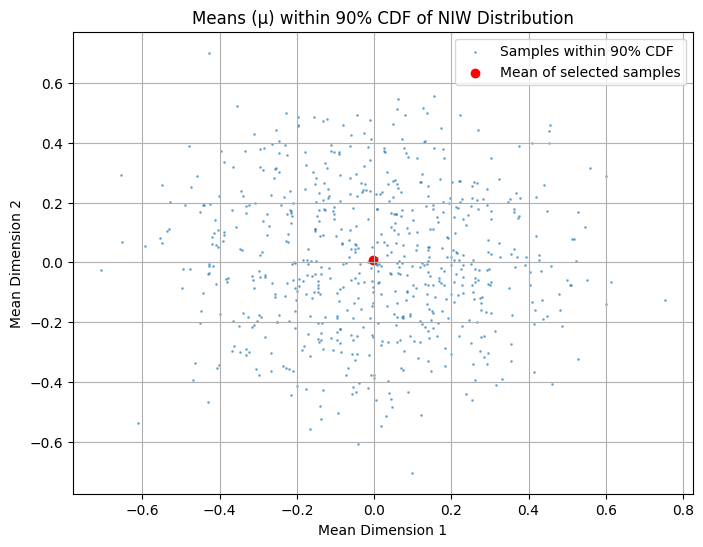

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invwishart, multivariate_normal

# NIW parameters
d = 2  # dimensionality
nu = 10  # degrees of freedom
Psi = np.eye(d)  # scale matrix
kappa = 1  # normalizing constant
m = np.zeros(d)  # mean vector

# Sampling from NIW
num_samples = 1000  # total number of samples
Sigma_samples = invwishart.rvs(df=nu, scale=Psi, size=num_samples)
mu_samples = np.array([multivariate_normal.rvs(mean=m, cov=Sigma / kappa) for Sigma in Sigma_samples])

# Joint probability approximation
joint_samples = np.hstack((mu_samples, Sigma_samples.reshape(num_samples, -1)))

# Sort samples by their estimated density and calculate cumulative probability
densities = np.array([multivariate_normal.pdf(mu_samples[i], mean=m, cov=Sigma_samples[i] / kappa)
                      for i in range(num_samples)])
sorted_indices = np.argsort(densities)[::-1]
cumulative_probs = np.cumsum(densities[sorted_indices]) / np.sum(densities)

# Select samples within the 90% CDF
boundary_idx = np.where(cumulative_probs >= 0.9)[0][0]
selected_mu = mu_samples[sorted_indices[:boundary_idx]]

# Compute the mean of the selected means (for visualization)
mean_mu = selected_mu.mean(axis=0)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(selected_mu[:, 0], selected_mu[:, 1], s=1, alpha=0.5, label='Samples within 90% CDF')
plt.scatter(mean_mu[0], mean_mu[1], color='red', label='Mean of selected samples')
plt.title("Means (\u03BC) within 90% CDF of NIW Distribution")
plt.xlabel("Mean Dimension 1")
plt.ylabel("Mean Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


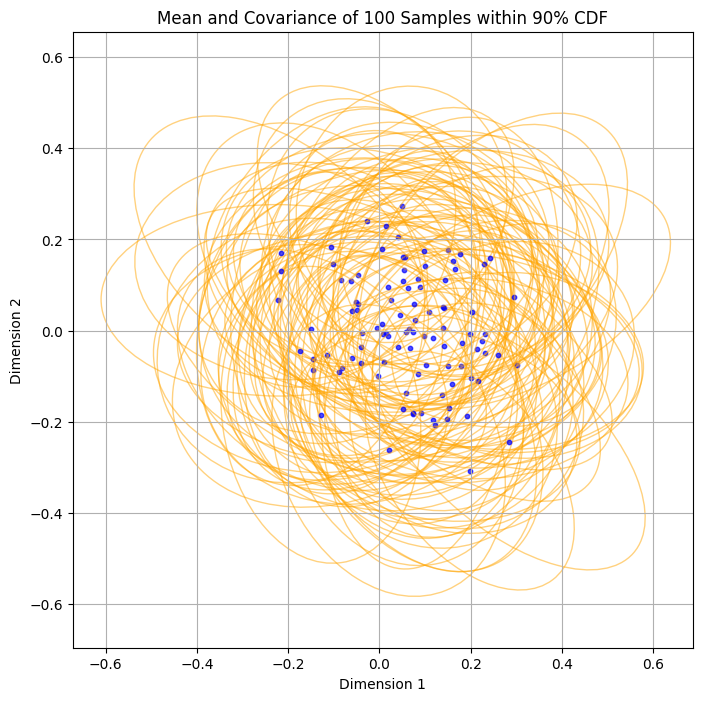

In [126]:
# Select 100 samples from the 90% CDF samples
num_visual_samples = 100
selected_indices = sorted_indices[:boundary_idx][:num_visual_samples]
visual_mu_samples = mu_samples[selected_indices]
visual_Sigma_samples = Sigma_samples[selected_indices]

# Plot each sample's mean and covariance
plt.figure(figsize=(8, 8))
for i in range(num_visual_samples):
    mu = visual_mu_samples[i]
    Sigma = visual_Sigma_samples[i]
    
    # Plot mean as a point
    plt.scatter(mu[0], mu[1], color='blue', s=10, alpha=0.7)
    
    # Plot covariance as an ellipse
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    width, height = 2 * np.sqrt(eigenvalues)  # Scale to represent ~1 std dev
    ellipse = plt.matplotlib.patches.Ellipse(
        xy=mu, width=width, height=height, angle=np.degrees(angle),
        edgecolor='orange', facecolor='none', lw=1, alpha=0.5)
    plt.gca().add_patch(ellipse)

plt.title("Mean and Covariance of 100 Samples within 90% CDF")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.show()
